/tmp/ipykernel_80/1514685542.py:7: DtypeWarning: Columns (74,75,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vehicles = pd.read_csv("vehicles.csv")
                  count       mean       std   min        25%        50%  \
started_driving                                                            
0                4427.0  28.536996  8.216077  14.0  24.333333  27.333333   
1                3614.0  29.321996  9.190357  14.0  24.750000  27.416667   

                   75%    max  
started_driving                
0                30.25  116.0  
1                31.00  116.0  


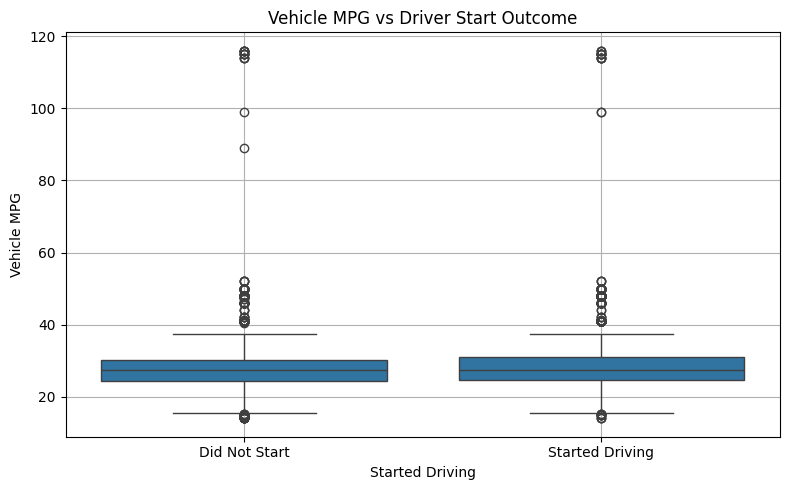

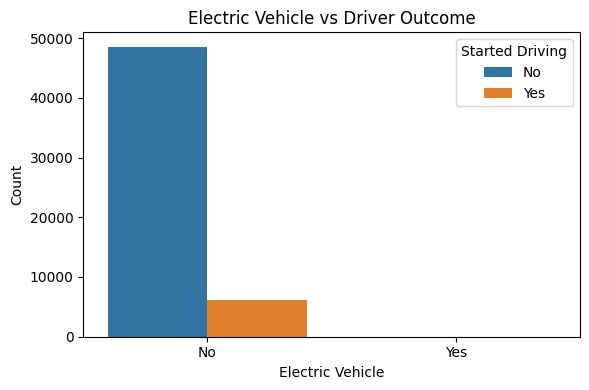

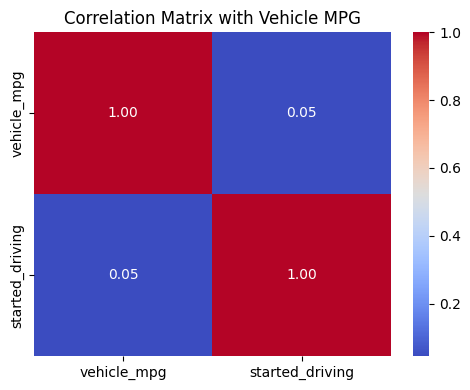

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load datasets
df_challenge = pd.read_csv("ds_challenge_v2_1_data.csv")
df_vehicles = pd.read_csv("vehicles.csv")

# Step 2: Clean EPA vehicle dataset
df_vehicles['make_clean'] = df_vehicles['make'].astype(str).str.lower().str.strip()
df_vehicles['model_clean'] = df_vehicles['model'].astype(str).str.lower().str.strip()

mpg_df = df_vehicles[['make_clean', 'model_clean', 'year', 'comb08', 'fuelType1']].copy()
mpg_df = mpg_df.groupby(['make_clean', 'model_clean', 'year'], as_index=False).agg({
    'comb08': 'mean',
    'fuelType1': lambda x: 'electricity' if any('electric' in str(v).lower() for v in x) else 'gas'
})
mpg_df['is_electric'] = mpg_df['fuelType1'].str.lower().str.contains('electric')
mpg_df.drop(columns='fuelType1', inplace=True)

# Step 3: Clean Uber dataset
df_challenge['vehicle_make_clean'] = df_challenge['vehicle_make'].astype(str).str.lower().str.strip()
df_challenge['vehicle_model_clean'] = df_challenge['vehicle_model'].astype(str).str.lower().str.strip()
df_challenge['vehicle_year'] = df_challenge['vehicle_year'].fillna(-1).astype(int)

# Step 4: Merge datasets
df_merged = pd.merge(
    df_challenge,
    mpg_df,
    how='left',
    left_on=['vehicle_make_clean', 'vehicle_model_clean', 'vehicle_year'],
    right_on=['make_clean', 'model_clean', 'year']
)

# Step 5: Final columns
df_merged['vehicle_mpg'] = df_merged['comb08'].dropna()
df_merged['is_electric'] = df_merged['is_electric'].fillna(False)
df_merged['started_driving'] = df_merged['first_completed_date'].notnull().astype(int)
df_merged.drop(columns=['make_clean', 'model_clean', 'year', 'comb08'], inplace=True)

# Step 6: MPG Summary
print(df_merged.groupby('started_driving')['vehicle_mpg'].describe())

# Step 7: Visualizations
# Boxplot: MPG vs driver outcome
plt.figure(figsize=(8, 5))
sns.boxplot(x='started_driving', y='vehicle_mpg', data=df_merged)
plt.title("Vehicle MPG vs Driver Start Outcome")
plt.xticks([0, 1], ['Did Not Start', 'Started Driving'])
plt.xlabel("Started Driving")
plt.ylabel("Vehicle MPG")
plt.grid(True)
plt.tight_layout()
plt.show()

# Countplot: Electric vehicle vs outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='is_electric', hue='started_driving', data=df_merged)
plt.title("Electric Vehicle vs Driver Outcome")
plt.xlabel("Electric Vehicle")
plt.ylabel("Count")
plt.xticks([0, 1], ['No', 'Yes'])
plt.legend(title="Started Driving", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(5, 4))
corr_matrix = df_merged[['vehicle_mpg', 'started_driving']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix with Vehicle MPG")
plt.tight_layout()
plt.show()


In [5]:
!pip install statsmodels==0.14.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 63.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import pandas as pd
import statsmodels.api as sm

# Step 1: Drop rows with missing vehicle_mpg AND drop any NaN values
df_clean = df_merged[df_merged['vehicle_mpg'] != -1].copy()
df_clean = df_clean.dropna(subset=['vehicle_mpg', 'started_driving'])

# Step 2: Define X (features) and y (target)
X = df_clean[['vehicle_mpg']]
X = sm.add_constant(X)  # Add intercept term
y = df_clean['started_driving']

# Step 3: Fit logistic regression
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Step 4: Show model summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.687014
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        started_driving   No. Observations:                 8041
Model:                          Logit   Df Residuals:                     8039
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Apr 2025   Pseudo R-squ.:                0.001472
Time:                        15:59:35   Log-Likelihood:                -5524.3
converged:                       True   LL-Null:                       -5532.4
Covariance Type:            nonrobust   LLR p-value:                 5.444e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5062      0.079     -6.382      0.000      -0.662      -0.351
vehicle_mpg     0.0105    